<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
!pip install torch-summary

import torch
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as tt
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary

import gc

import os
import copy
import numpy as np
import pandas as pd
import random
import cv2
import statistics
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from skimage.transform import resize
from PIL import Image, ImageDraw
from IPython.display import clear_output

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [111]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Tue May 21 16:45:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              32W / 250W |  11186MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+----------------------

In [3]:
# fixing the seed
SEED = 2024
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
DATA_DIR = '/kaggle/input/faces-dataset-small'

In [5]:
def get_dataloader(image_size, batch_size):
  # resize images, convert them to tensors and build dataloader
  transform = tt.Compose([tt.Resize(image_size),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize it from -1 ... 1
  dataset = ImageFolder(DATA_DIR, transform)
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [6]:
image_size = 64
batch_size = 128
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # avs and stds 
#build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)

In [7]:
def denorm(img_tensors):
    '''from (-1 ... 1) to (0 ... 1)'''
    return img_tensors * stats[1][0] + stats[0][0]

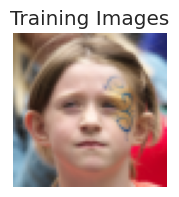

In [110]:
batch, _ = next(iter(dataloader))
plt.figure(figsize=(2, 2))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(denorm(batch.to(device)[:1]), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [8]:
def weights_init(m):
    '''Initialize weights'''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Помимо классических слоев свертки + батчнорм + функция активации, добавим также слой дропаут с небольшим значением p = 0.05

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # input
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.05),

        nn.Conv2d(in_channels=64, out_channels=64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64 * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.05),

        nn.Conv2d(in_channels=64 * 2, out_channels=64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64 * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.05),

        nn.Conv2d(in_channels=64 * 4, out_channels=64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64 * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.05),
        
        # output
        nn.Conv2d(in_channels=64 * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Flatten(),
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [10]:
from torchinfo import summary
summary(Discriminator().to('cpu').apply(weights_init), (batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,072
│    └─BatchNorm2d: 2-2                  [128, 64, 32, 32]         128
│    └─LeakyReLU: 2-3                    [128, 64, 32, 32]         --
│    └─Dropout: 2-4                      [128, 64, 32, 32]         --
│    └─Conv2d: 2-5                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-6                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-7                    [128, 128, 16, 16]        --
│    └─Dropout: 2-8                      [128, 128, 16, 16]        --
│    └─Conv2d: 2-9                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-10                 [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-11                   [128, 256, 8, 8]          --

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__() 
    self.main = nn.Sequential(
        # latent vector z
#         nn.ConvTranspose2d(in_channels=latent_size, out_channels=64 * 16, kernel_size=4, stride=1, padding=1, bias=False),
#         nn.BatchNorm2d(64 * 16),
#         nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=latent_size, out_channels=64 * 8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(64 * 8),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.ConvTranspose2d(in_channels=64 * 8, out_channels=64*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64 * 4),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.ConvTranspose2d(in_channels=64 * 4, out_channels=64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64 * 2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        # output 3 * 64 * 64
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
  def forward(self, input):
    return self.main(input)

In [12]:
from torchinfo import summary
summary(Generator().to('cpu').apply(weights_init), (batch_size, latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 3, 64, 64]          --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          1,048,576
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-3                    [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-6                    [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-9                    [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 3

In [112]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = Generator()(xb)

In [119]:
def show_images(fake_images):
    '''for visualizing images created by the generator'''
    fig, ax = plt.subplots(figsize=(1, 2))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images[:1].cpu().detach()), nrow=8).permute(1, 2, 0))

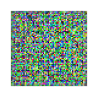

In [120]:
show_images(fake_images)

**Начинаем с рандомного шума...**

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

Ниже заданы разные значения learning rate для дискриминатора и генератора. Подобраны эмпирически, исходя из следующей логики: дискриминатор, очевидно на первых эпохах будет легко отличать "шум" от реальных изображений, поэтому lr должна быть чуть меньше по сравнению с lr генератора. Небольшое отличие между значениями lr призвано также не допустить получения генератором подавляющего преимущества над дискриминатором в процессе обучения.

In [27]:
lr_D = 0.0004
lr_G = 0.0005

In [28]:
# model + weights init.
model = {
    "discriminator": Discriminator().to(device).apply(weights_init),
    "generator": Generator().to(device).apply(weights_init)
}

# losses for each model
criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
# opts
optimizer = {
    "discriminator": torch.optim.AdamW(model["discriminator"].parameters(), 
                                      lr=lr_D, betas=(0.5, 0.999),
                                      eps=1e-8, weight_decay=1e-5, amsgrad=False),
    "generator": torch.optim.AdamW(model["generator"].parameters(),
                                  lr=lr_G, betas=(0.5, 0.999),
                                  eps=1e-8, weight_decay=1e-5, amsgrad=False)}

In [19]:
# scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer["discriminator"], patience=10)
# scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer["generator"], patience=10)

In [29]:
def fit(model, criterion, epochs, optimizer):
    # Переведём модели в режим обучения
    model["discriminator"].to(device).train()
    model["generator"].to(device).train()
    torch.cuda.empty_cache()    
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images,_ in tqdm(dataloader):
            
            #Discriminator Training
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()
            real_preds = model["discriminator"](real_images)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.99, 1.0).to(device) #LabelSmoothing
            
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # fake images generation
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            fake_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.0, 0.01).to(device) #LabelSmoothing
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # updating the discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())
            
            #Generator Training
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.99, 1.0).to(device) #LabelSmoothing
            loss_g = criterion["generator"](preds, targets)
            
            # updating the generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
   
        # recording average losses and average scores for epoch
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
#         scheduler_D.step(np.mean(loss_d_per_epoch))
#         scheduler_G.step(np.mean(loss_g_per_epoch))

        # Visualisation
        clear_output(wait=True)
        plt.figure(figsize=(12,12))
        plt.title("Epoch [{}/{}], loss_g: {:.3f}, loss_d: {:.3f}, real_score: {:.3f}, fake_score: {:.3f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        plt.axis("off")
        plt.imshow(np.transpose(make_grid(fake_images.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.tight_layout()
        plt.show()  
    return losses_g, losses_d, real_scores, fake_scores

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

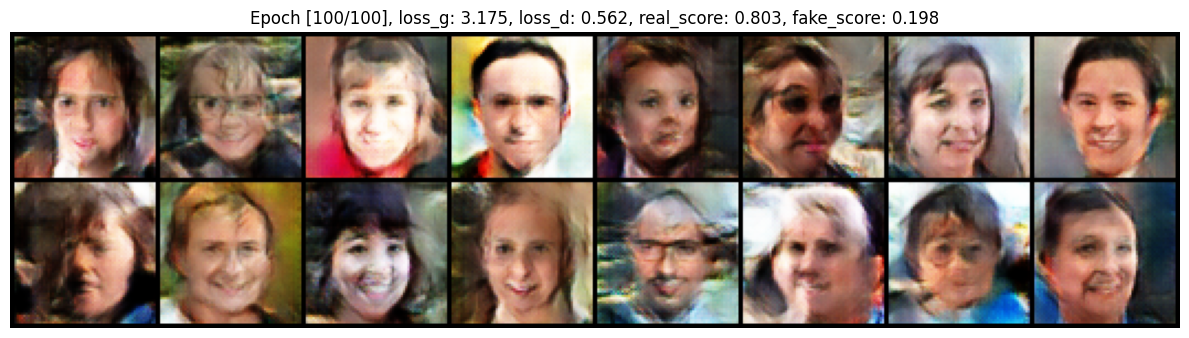

In [36]:
history = fit(model, criterion, 100, optimizer)

In [37]:
losses_g, losses_d, real_scores, fake_scores = history

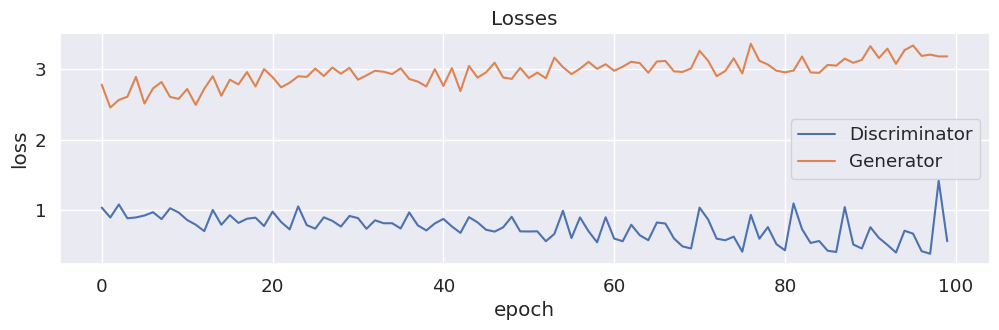

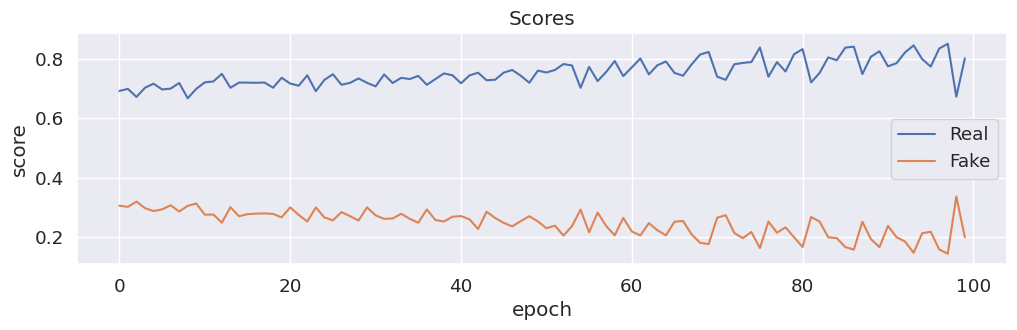

In [125]:
plt.figure(figsize=(12, 3))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

plt.figure(figsize=(12, 3))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

В первую очередь, хочу отметить, что ранее модель DCGAN была обучена на 40 эпохах, поэтому график обучения G & D на последующих 100 эпохах не имеет характерного для первых эпох поведения (для D - резкое увеличение с "низкого старта" с последующим выравниванием и понижением; для G - резкое уменьшение потерь с "высокого старта", с последующим плавным повышением потерь).

В целом, графики losses & scores демонстрируют характерное для обучения GAN's поведение: кривые графиков, примерно, до 55-60 эпохи колеблются в небольшом интервале значений, что демонстрирует нек. баланс, достигнутый между противоположными устремлениями G & D. После 55-60 эпохи появляется больше стохастиктики, достигая макс. колебаний, как раз, к 100 эпохе. На мой взгляд, обучение можно было прекратить на 60 эпохе.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [81]:
def show_images(generated):
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(make_grid(generated.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

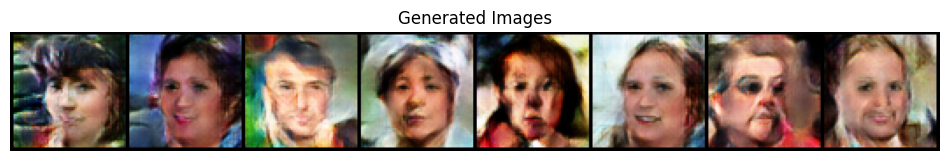

In [82]:
n_images = 8

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

**В целом, сгенерировованные лица близки к реальным, смазанность контуров лиц, полагаю, связана с тем, что модели тяжело дается генерация фона + накладка друг на друга схож. признаков из полученного латентного пространства. У пары лиц порядок со всеми значимыми частями: глаза, волосы, нос, рот и т.д. Глаза у всех лиц прорисаваны достаточно точно**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

**Сгенерируем фейковые изображения с помощью обученной модели**

In [88]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [87]:
dataset = ImageFolder(DATA_DIR)
n_images = len(dataset)
latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"].to(device)(latent)
real_images = next(iter(get_dataloader(64, n_images)))[0]

**обучим 1NN Classifier**

In [89]:
# сгенерируем равные по длине тензоры, состоящие из 0 и 1
zeros = torch.zeros(n_images, 1, device='cpu')
ones = torch.ones(n_images, 1, device='cpu')
# последовательно сконкатенируем фейковые и реальные изображения, а также тензоры, состоящие из 0 и 1 + сохраним их в соотв. переменных Х и у 
X = torch.cat((fake_images.cpu(), real_images.cpu())).detach().numpy().reshape(-1, 3*64*64)
y = torch.cat((zeros, ones)).detach().numpy()

knc = KNeighborsClassifier(n_neighbors=1)
LOO = LeaveOneOut()

accuracy_scores = []
predictions = []
targets = []

for train_index, test_index in tqdm(LOO.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knc.fit(X_train, np.ravel(y_train))
    pred = knc.predict(X_test)
    accuracy_scores.append(accuracy_score(pred, y_test))
    predictions.append(pred)
    targets.append(y_test)

0it [00:00, ?it/s]

In [90]:
print('accuracy =', np.mean(accuracy_scores))

accuracy = 0.748488705058861


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Обученная модель 1NN Classifier распознает изображения с точностью ~ 0.75, то есть около 25% фейковых изображений модель распознать не смогла. В идеале, конечно, было бы получить значение равное 0.5. Тогда бы из этого следовало, что классификатор не смог найти значимых отличий между реальными и фейковыми картинками (настолько они похожи).**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [107]:
X_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

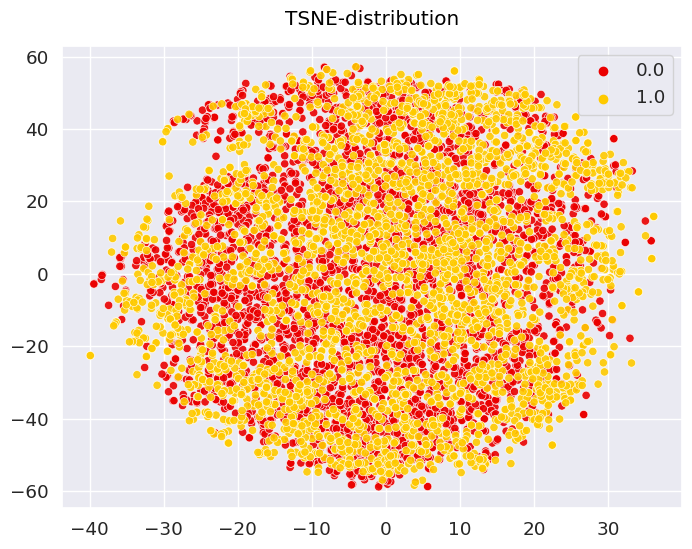

In [136]:
x1, x2 = zip(*X_emb_tsne)
sns.set(rc={'figure.figsize': (8, 6)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x=x1, y=x2, hue=y.ravel(), alpha=0.9, palette="hot")
plt.title('TSNE-distribution', color = 'black', pad = 15)
plt.show()

Прокомментируйте получившийся результат:

**Полученное TSNE-распределение не позволяет хоть как-то однозначно выделить кластеры, соответствующие меткам "0" и "1". За исключением нек. небольших участков распределения указанных точек очень похожи и довольно равномерно перемешаны (распределение 0 более "размазанное" и равномерное).**

TSNE-распределение меток центрировано относительно нуля по каждой из компонент, то есть близко к стандарт. норм. распределению.

**Схожесть распределения классов фейковых и реальных изображений, вкупе с показателем accuracy выше, говорит о том, что наше скрытое пространство позволяет нам генерировать близкие к оригинальным изображения, что хорошо.**